# Playing Hard Exploration Games by Watching YouTube

 - **Paper**: Aytar et al., DeepMind
 - **Code**: Seungjae Ryan Lee, [endtoendAI](https://www.endtoend.ai/)

## Table of Contents

1. [Pretraining Embeddings](#Pretraining-Embeddings)
   - [Models](#Models)
   - [Dataset](#Dataset)
   - [Pretraining](#Pretraining)
   - [t-SNE](#t-SNE)
   - [Cycle Consistency](#Cycle-Consistency)
6. [CMC Data](#CMC-Data)

## Setup

In [1]:
import torch
import torch.optim as optim

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Pretraining Embeddings

### Models

Check [tdc.py](/networks/tdc.py), [cmc.py](/networks/cmc.py), and [classifier.py](/networks/classifier.py) in `networks/`.

In [3]:
from networks import TDC, CMC, Classifier

In [4]:
tdc = TDC().to(device)
cmc = CMC().to(device)
tdc_classifier = Classifier().to(device)
cmc_classifier = Classifier().to(device)

In [5]:
print(tdc)

TDC(
  (conv_layers): Sequential(
    (0): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): ResidualBlock(
      (layers): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, 

In [6]:
print(cmc)

CMC(
  (conv_layers): Sequential(
    (0): Conv1d(256, 32, kernel_size=(8,), stride=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv1d(32, 64, kernel_size=(8,), stride=(1,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): Conv1d(64, 128, kernel_size=(8,), stride=(1,))
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Conv1d(128, 256, kernel_size=(8,), stride=(1,))
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

In [7]:
print(tdc_classifier)

Classifier(
  (layers): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=6, bias=True)
  )
)


In [8]:
print(cmc_classifier)

Classifier(
  (layers): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=6, bias=True)
  )
)


As a reference, let's see how many parameters each network has.

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [10]:
print('TDC has {:8d} parameters.'.format(count_parameters(tdc)))
print('CMC has {:8d} parameters.'.format(count_parameters(cmc)))
print('TDC classifier has {} parameters.'.format(count_parameters(tdc_classifier)))
print('CMC classifier has {} parameters.'.format(count_parameters(cmc_classifier)))

TDC has 18109408 parameters.
CMC has   936352 parameters.
TDC classifier has 1055750 parameters.
CMC classifier has 1055750 parameters.


### Dataset

Check [tddccmcdataset.py](datasets/tdccmcdataset.py) in `datasets/`.

In [11]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from datasets import TDCCMCDataset

In [12]:
dataset = TDCCMCDataset(
    filenames=['./data/6zXXZvVvTFs'],
    trims=[(9, 129)],
    crops=[(35, 50, 445, 300)]
)

In [13]:
loader = DataLoader(dataset, batch_size=1, num_workers=0)

As a sanity check, let's see how frames are processed.

In [14]:
v, w, a, tdc_label, cmc_label = next(iter(loader))

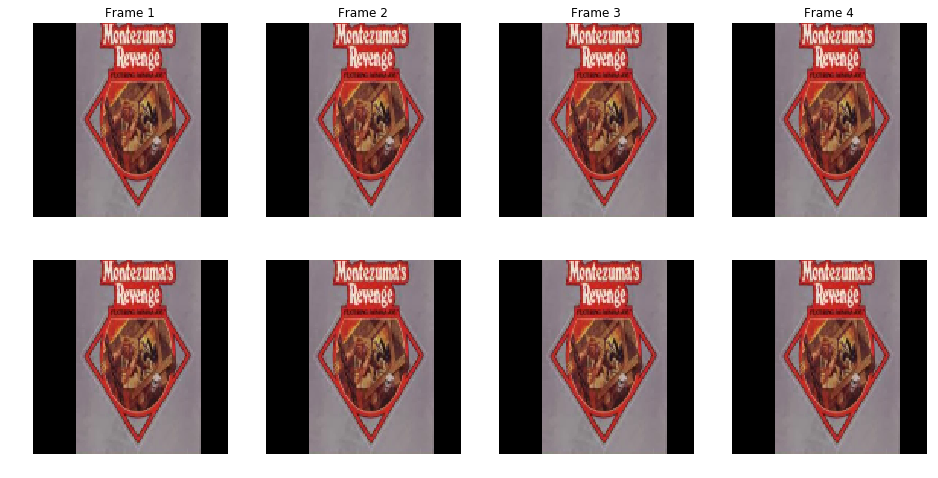

Interval:  3


In [15]:
v = v[0].permute(1, 2, 0)
w = w[0].permute(1, 2, 0)
v1, v2, v3, v4 = v[:, :, 0:3], v[:, :, 3:6], v[:, :, 6:9], v[:, :, 9:12]
w1, w2, w3, w4 = w[:, :, 0:3], w[:, :, 3:6], w[:, :, 6:9], w[:, :, 9:12]
fig = plt.figure(figsize=(16, 8))
fig.add_subplot(2, 4, 1)
plt.imshow(v1)
plt.axis('off')
plt.title('Frame 1')
fig.add_subplot(2, 4, 2)
plt.imshow(v2)
plt.axis('off')
plt.title('Frame 2')
fig.add_subplot(2, 4, 3)
plt.imshow(v3)
plt.axis('off')
plt.title('Frame 3')
fig.add_subplot(2, 4, 4)
plt.imshow(v4)
plt.axis('off')
plt.title('Frame 4')
fig.add_subplot(2, 4, 5)
plt.imshow(w1)
plt.axis('off')
fig.add_subplot(2, 4, 6)
plt.imshow(w2)
plt.axis('off')
fig.add_subplot(2, 4, 7)
plt.imshow(w3)
plt.axis('off')
fig.add_subplot(2, 4, 8)
plt.imshow(w4)
plt.axis('off')
plt.show()
print('Interval: ', tdc_label[0].item())

In [16]:
# CLeanup
del v, w, a, tdc_label, cmc_label, v1, v2, v3, v4, w1, w2, w3, w4, fig

### Pretraining

Check [train_embeddings.py](/train_embeddings.py) in root directory.

We won't actually pretrain our embedding in this notebook, since it is very intensive.

In [17]:
from train_embeddings import train_embeddings

In [18]:
LR = 1e-4
CMC_LAMBDA = 1
NB_STEPS = 10

In [20]:
# Initialize Optimizer
optim_params = list(tdc.parameters()) + list(cmc.parameters()) + list(tdc_classifier.parameters()) + list(cmc_classifier.parameters())
optimizer = optim.Adam(optim_params, lr=LR)

In [21]:
# Train Embeddings
train_embeddings(loader, tdc, cmc, tdc_classifier, cmc_classifier, optimizer, device, CMC_LAMBDA, NB_STEPS)
print('[train] Finished training.')

RuntimeError: dimension specified as 0 but tensor has no dimensions

In [ ]:
del dataset, loader, LR, CMC_LAMBDA, NB_STEPS

Instead of pretraining, we will load pretrained models.

In [ ]:
from commons import load_models

In [24]:
load_models(tdc, cmc, tdc_classifier, cmc_classifier, optimizer)

['1543388350.pth']
./saves/1543388350.pth


### t-SNE

Check [tsne.py](/tsne.py) in root directory.

In [ ]:
from tsne import plot_tsne

In [ ]:
filenames = [
    './data/2AYaxTiWKoY',
    './data/6zXXZvVvTFs',
]
trims = [
    (0, 250),
    (0, 250),
]
crops = [
    (0, 0, 140, 140),
    (0, 0, 140, 140),
]

In [ ]:
plot_tsne(filenames, trims, crops, tdc, cmc, device)

### Cycle Consistency

<div class="alert alert-warning">
TODO Incomplete
</div>

First, we prepare two length-$N$ videos: $V$ and $W$.

In [32]:
# Determine N
N = min([len(embed) for embed in embeds])
N = N - N % 4
nb_stacks = N // 4
print('N      :', N)
print('Stacks :', nb_stacks)

N      : 1196
Stacks : 299


Then, we embed each frame stack of these videos with the learned embedding vector $\phi$.

To evaluate cycle-consistency, we first pick some random frame $v_i$ from the video $V$.

In [33]:
i = np.random.randint(len(embeds[0]))
vi = embeds[0][i]
print(i)

410


Then, we calculate the nearest neighbor $w_j$ of $v_i$ in the embedding space. In other words,

$$
w_j = \text{argmin}_{w \in W} d_\phi (v_i, w)
$$

In [34]:
min_distance_j = 9999999999999999999
min_index_j = 0
min_frame_j = embeds[1][0]
for j, wj in enumerate(embeds[1]):
    distance = ((vi - wj)**2).mean()
    if distance < min_distance_j:
        min_distance_j = distance
        min_index_j = j
        min_frame_j = wj

In [35]:
print(min_index_j)

402


Then, we again calculate the nearest neighbor $v_k$ of $w_j$ in the embedding space. In other words,

$$
v_k = \text{argmin}_{v \in V} d_\phi (v, w_j)
$$

In [36]:
min_distance_k = 9999999999999999999
min_index_k = 0
min_frame_k = embeds[0][0]
for k, vk in enumerate(embeds[1]):
    distance = ((wj - vk)**2).mean()
    if distance < min_distance_k:
        min_distance_k = distance
        min_index_k = k
        min_frame_k = vk

In [37]:
print(min_index_k)

1196


If $v_i = v_k$, we say that $v_i$ is cycle-consistent.

In [38]:
if i == min_index_k:
    print('v_i is cycle-consistent')
else:
    print('v_i is NOT cycle-consistent')

v_i is NOT cycle-consistent
